# Shipping Emissions
Share of total CO<sub>2</sub> emissions attributable to maritime bunker fuel, by country by year.

Note that this is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted.  

_Author: Peter Kerins_  
_Created: 26 Aug 2021_  
_Environment: jupyterlab_  

## Style
- Vega chart
- Ocean Watch country page - parameterized chart
- Time series
- Line chart

## Data
Underlying dataset: [com.038 Shipping Emissions](https://resourcewatch.carto.com/u/wri-rw/dataset/com_038_rw0_shipping_emissions_edit)  
Widget data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (master table for all territory-based widgets on Ocean Watch)  

## Preparation

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 400
widget_height = 300

# County Widget

## Demo Query
`gid_0 = <territory>` used as stand-in for parameterization
```sql
SELECT gid_0, name_0, date, value/100.0 AS value
FROM ow_widget_territory
WHERE widget = 'shipping_emissions'
AND gid_0 = 'CAN'
```

## Parameterized Query
```sql
SELECT data.gid_0, data.name_0, data.date, data.value/100.0 AS value
FROM ow_widget_territory AS data
LEFT OUTER JOIN gadm36_0 AS gadm ON data.gid_0 = gadm.gid_0
WHERE data.widget = 'shipping_emissions'
AND gadm.{{geostore_env}}='{{geostore_id}}'
ORDER BY data.date ASC
```

## Specification
Vega code presumes RW-style `config` element present

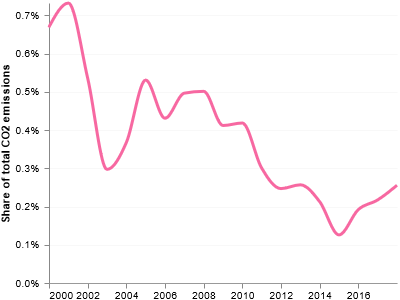

In [4]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Share of national/territorial CO2 emissions due to maritime bunker fuels",
  "width": 400,
  "height": 250,
  "padding": 0,
  "autosize": {"type": "fit", "contains": "padding"},
  "signals": [],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gid_0, name_0, date, value/100.0 AS value FROM ow_widget_territory WHERE widget = 'shipping_emissions' AND gid_0 = 'CAN'",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {"date": "utc:'%Y-%m-%d'"}
      },
      "transform": []
    }
  ],
  "scales": [
    {
      "name": "datescale",
      "type": "time",
      "domain": {"data": "table", "field": "date"},
      "range": "width"
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {
        "data": "table", 
        "fields": ["value"]
      },
      "range": "height",
      "padding": 0.1
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "datescale",
      "domain": true,
      "labelFlush": true,
      "labelOverlap": true,
      "labelBaseline": "middle",
      "ticks": true,
      "grid": false,
      "labelFontSize": 10,
      "labelFont": "Arial",
      "labelPadding": 7
    },
    {
      "orient": "left",
      "scale": "yscale",
      "domain": true,
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 5,
      "grid": true,
      "gridOpacity": 0.2,
      "labelFontSize": 10,
      "labelFont": "Arial",
      "format": ".1%",
      "title": "Share of total CO2 emissions"
    }
  ],
  "marks": [
    {
      "type": "line",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "date"},
          "y": {"scale": "yscale", "field": "value"},
          "stroke": {"value": "#f768a1"},
          "strokeWidth": {"value": 3},
          "clip": {"value": true},
          "interpolate": {"value": "monotone"},
          "tooltip": {
            "signal": "{'Year':utcFormat(datum.date,'%Y'), 'Share of emissions':format(datum.value,'.1%')}"
          }
        },
        "update": {
          "strokeOpacity": {"value": 1}
        },
        "hover": {
          "strokeOpacity": {"value": 0.5}
        }
      }
    }
  ],
  "legends": [
  ]
}
""")
vega_view=dict(spec)
vega_view['width']=widget_width
vega_view['height']=widget_height
Vega(vega_view)

# Global Widget

## Queries
Basic data selection, subsequently transformed via `facet` within specification
```sql
SELECT gid_0, name_0, date, value/100.0 AS value
FROM ow_widget_territory
WHERE widget = 'shipping_emissions'
```

Identifying "top" countries to reduce clutter (here limited to 15 countries)
```sql
SELECT gid_0, name_0, MAX(value/100.0) AS max_value 
FROM ow_widget_territory 
WHERE widget = 'shipping_emissions'
GROUP BY gid_0, name_0
ORDER BY max_value DESC
LIMIT 15
```

Combination query to include all records from "top" _n_ countries
```sql
SELECT main.gid_0, main.name_0, main.date, main.value/100.0 AS value
FROM ow_widget_territory AS main
INNER JOIN (
  SELECT gid_0, name_0, MAX(value/100.0) AS max_value 
  FROM ow_widget_territory 
  WHERE widget = 'shipping_emissions'
  GROUP BY gid_0, name_0
  ORDER BY max_value DESC
  LIMIT 15) AS sub
ON main.gid_0 = sub.gid_0
WHERE widget = 'shipping_emissions'
```

## Specification
Vega code presumes RW-style `config` element present

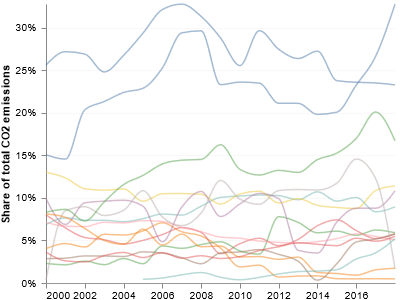

In [5]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Share of national/territorial CO2 emissions due to maritime bunker fuels",
  "width": 400,
  "height": 250,
  "padding": 0,
  "autosize": {"type": "fit", "contains": "padding"},
  "signals": [
    {
      "name": "active_name",
      "value": "",
      "on": [
        {"events": "*:mouseover", "update": "datum.name_0"}
      ]
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT main.gid_0, main.name_0, main.date, main.value/100.0 AS value FROM ow_widget_territory AS main INNER JOIN (SELECT gid_0, name_0, MAX(value/100.0) AS max_value FROM ow_widget_territory WHERE widget = 'shipping_emissions' GROUP BY gid_0, name_0 ORDER BY max_value DESC LIMIT 15) AS sub ON main.gid_0 = sub.gid_0 WHERE widget = 'shipping_emissions'",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {"date": "utc:'%Y-%m-%d'"}
      },
      "transform": []
    }
  ],
  "scales": [
    {
      "name": "datescale",
      "type": "time",
      "domain": {"data": "table", "field": "date"},
      "range": "width"
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {
        "data": "table", 
        "fields": ["value"]
      },
      "range": "height",
      "padding": 0.1
    },
    {
      "name": "colorscale",
      "type": "ordinal",
      "domain": {
        "data": "table",
        "field": "name_0"
      },
      "range": "category"
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "datescale",
      "domain": true,
      "labelFlush": true,
      "labelOverlap": true,
      "labelBaseline": "middle",
      "ticks": true,
      "grid": false,
      "labelFontSize": 10,
      "labelFont": "Arial",
      "labelPadding": 7
    },
    {
      "orient": "left",
      "scale": "yscale",
      "domain": true,
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 5,
      "grid": true,
      "gridOpacity": 0.2,
      "labelFontSize": 10,
      "labelFont": "Arial",
      "format": ".0%",
      "title": "Share of total CO2 emissions"
    }
  ],
  "marks": [
    {
      "type": "text",
      "name": "net-label",
      "encode": {
        "enter": {
          "font": {"value": "Arial"},
          "fontSize": {"value": 14},
          "fontWeight": {"value": "normal"},
          "fontStyle": {"value": "normal"},
          "fill": {"value": "grey"},
          "baseline": "middle",
          "text": {
            "signal": "active_name"
          },
          "x": {"signal": "width", "mult": 0.03},
          "y": {"signal": "height", "mult": 0.08}
        },
        "update": {
          "text": {
            "signal": "active_name"
          },
          "fill": {"signal": "scale('colorscale',active_name)"}
        }
      }
    },
    {
      "type": "group",
      "from": {
        "facet": {
          "name": "series",
          "data": "table",
          "groupby": "gid_0"
        }
      },
      "marks": [
        {
          "type": "line",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "datescale", "field": "date"},
              "y": {"scale": "yscale", "field": "value"},
              "stroke": {"scale": "colorscale", "field": "name_0"},
              "clip": {"value": true},
              "interpolate": {"value": "monotone"},
              "tooltip": {
                "signal": "{'Country':datum.name_0,'Year':utcFormat(datum.date,'%Y'), 'Share of emissions':format(datum.value,'.1%')}"
              }
            },
            "update": {
              "strokeWidth": {"signal": "datum.name_0 == active_name ? 2.0 : 1.5"},
              "strokeOpacity": {"signal": "datum.name_0 == active_name ? 1.0 : 0.5"}
            },
            "hover": {
              "strokeOpacity": {"value": 1.0}
            }
          }
        },
        {
          "type": "symbol",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "datescale", "field": "date"},
              "y": {"scale": "yscale", "field": "value"},
              "stroke": {"scale": "colorscale", "field": "name_0"},
              "strokeWidth": {"value": 1.5},
              "size": {"signal": "width/6"},
              "tooltip": {
                "signal": "{'Country':datum.name_0,'Year':utcFormat(datum.date,'%Y'), 'Share of emissions':format(datum.value,'.1%')}"
              }
            },
            "update": {
              "fill": {"value": "white"},
              "fillOpacity": {"value": 0.0},
              "strokeOpacity": {"signal": "datum.name_0 == active_name ? 1.0 : 0.0"}
            },
            "hover": {
              "fill": {"scale": "colorscale", "field": "name_0"},
              "fillOpacity": {"value": 1.0}
            }
          }
        }
      ]
    }
  ],
  "legends": [
  ]
}
""")
vega_view=dict(spec)
vega_view['width']=widget_width
vega_view['height']=widget_height
Vega(vega_view)

#Indicator

```sql
SELECT CASE 
    WHEN value < 1 AND value > 0 THEN '<1' 
    WHEN  value >= 1 THEN CAST(ROUND(CAST(value AS NUMERIC),2) AS TEXT)  
    ELSE '0' END AS value 
    FROM com_038_rw0_shipping_emissions_edit 
INNER JOIN gadm36_0 gadm ON gid_0 ILIKE iso 
WHERE datetime = CAST('2018-01-01' AS date) AND {{geostore_env}} ILIKE '{{geostore_id}}'
```
query: [`https://wri-rw.carto.com/api/v2/sql?q=SELECT CASE WHEN value < 1 AND value > 0 THEN '<1' WHEN  value >= 1 THEN CAST(ROUND(CAST(value AS NUMERIC),2) AS TEXT) ELSE '0' END AS value  FROM com_038_rw0_shipping_emissions_edit INNER JOIN gadm36_0 gadm ON gid_0 ILIKE iso WHERE datetime = CAST('2018-01-01' AS date) AND {{geostore_env}} ILIKE '{{geostore_id}}'`](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20CASE%20WHEN%20value%20%3C%201%20AND%20value%20%3E%200%20THEN%20%27%3C1%27%20WHEN%20%20value%20%3E=%201%20THEN%20CAST(ROUND(CAST(value%20AS%20NUMERIC),2)%20AS%20TEXT)%20ELSE%20%270%27%20END%20AS%20value%20%20FROM%20com_038_rw0_shipping_emissions_edit%20INNER%20JOIN%20gadm36_0%20gadm%20ON%20gid_0%20ILIKE%20iso%20WHERE%20datetime%20=%20CAST(%272018-01-01%27%20AS%20date)%20AND%20gid_0%20ILIKE%20%27AUS%27)

# RW API

Parameterized widgets created via [widget scripts](https://github.com/resource-watch/data-team-tools/tree/master/advanced_widget_writer).  

[com.038.rw0 Shipping Emissions](https://resourcewatch.org/data/explore/c9937085-22ec-4f8c-b819-5fa02473abdb) ([Admin](https://resourcewatch.org/admin/data/datasets/c9937085-22ec-4f8c-b819-5fa02473abdb/edit))  
`c9937085-22ec-4f8c-b819-5fa02473abdb`  
[Dataset](https://api.resourcewatch.org/v1/dataset/c9937085-22ec-4f8c-b819-5fa02473abdb/), [Widgets](https://api.resourcewatch.org/v1/dataset/c9937085-22ec-4f8c-b819-5fa02473abdb/widget)

In [6]:
dataset_id = 'c9937085-22ec-4f8c-b819-5fa02473abdb'
name = 'Shipping Emissions'
description = 'Share of national/territorial CO2 emissions due to maritime bunker fuels'

- [Country](https://api.resourcewatch.org/v1/widget/830f2880-527c-4272-8aaf-8ff8d87a83a8?env=production) `830f2880-527c-4272-8aaf-8ff8d87a83a8`  
- [Global](https://api.resourcewatch.org/v1/widget/8d7a8386-9723-454e-9139-cd0fceb02d24?env=production) `8d7a8386-9723-454e-9139-cd0fceb02d24`  